In [1]:
# ✅ Core Libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ✅ TensorFlow/Keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# ✅ Sklearn for Evaluation
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    multilabel_confusion_matrix,
    roc_auc_score,
    roc_curve,
    auc
)
from sklearn.preprocessing import label_binarize

In [2]:
# 🔁 Set Paths 
train_dir = "Training"  
test_dir = "Testing"    

# 🖼️ Image Size & Batch
img_size = 224
batch_size = 32

# 🔧 Data Augmentation for Training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# 🔍 Only Rescale for Testing
test_datagen = ImageDataGenerator(rescale=1./255)

# 🏋️ Training Generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical'
)

# 🧪 Test Generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# 🔠 Class Info
class_names = list(train_generator.class_indices.keys())
num_classes = len(class_names)

Found 4800 images belonging to 4 classes.
Found 1200 images belonging to 4 classes.


In [3]:
# ⚙️ Load VGG16 Base Model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
base_model.trainable = True  # Enable fine-tuning

# ➕ Custom Classifier Head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(num_classes, activation='softmax')(x)

# 🎯 Final Model
model_vgg16 = Model(inputs=base_model.input, outputs=output)

# 🧪 Compile
model_vgg16.compile(
    optimizer=Adam(learning_rate=0.00005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 📉 Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)

In [4]:
model_path = "vgg16_brain_tumor.h5"

if os.path.exists(model_path):
    print("✅ Loading saved VGG16 model...")
    model_vgg16 = load_model(model_path)
else:
    print("🚀 Training new VGG16 model...")
    history_vgg16 = model_vgg16.fit(
        train_generator,
        validation_data=test_generator,
        epochs=10,
        callbacks=[early_stop, lr_reduce]
    )
    model_vgg16.save(model_path)
    print("✅ Model trained and saved as", model_path)

🚀 Training new VGG16 model...


C:\Users\chand\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 2484s 17s/step - accuracy: 0.5404 - loss: 1.0487 - val_accuracy: 0.8208 - val_loss: 0.5500 - learning_rate: 5.0000e-05
Epoch 2/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 2573s 17s/step - accuracy: 0.8586 - loss: 0.3822 - val_accuracy: 0.8458 - val_loss: 0.4654 - learning_rate: 5.0000e-05
Epoch 3/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 2351s 16s/step - accuracy: 0.9293 - loss: 0.2194 - val_accuracy: 0.8742 - val_loss: 0.3783 - learning_rate: 5.0000e-05
Epoch 4/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 2326s 16s/step - accuracy: 0.9170 - loss: 0.2337 - val_accuracy: 0.9458 - val_loss: 0.1477 - learning_rate: 5.0000e-05
Epoch 5/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 2391s 16s/step - accuracy: 0.9380 - loss: 0.1687 - val_accuracy: 0.9508 - val_loss: 0.1576 - learning_rate: 5.0000e-05
Epoch 6/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 2359s 16s/step - accuracy: 0.9660 - loss: 0.1128 - val_accuracy: 0.9200 - val_loss: 0.2130 - learning_rate: 5.0000e-05
Epoch 7/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 2412s 

✅ Model trained and saved as vgg16_brain_tumor.h5


In [5]:
# 📉 Evaluate on test set
loss, acc = model_vgg16.evaluate(test_generator)
y_probs = model_vgg16.predict(test_generator)
y_pred = np.argmax(y_probs, axis=1)
y_true = test_generator.classes

# 🧾 Classification Report
cr = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)

# 🔢 Confusion Matrix & Metrics
cm = confusion_matrix(y_true, y_pred)
mcm = multilabel_confusion_matrix(y_true, y_pred)
tp = mcm[:, 1, 1].sum()
tn = mcm[:, 0, 0].sum()
fp = mcm[:, 0, 1].sum()
fn = mcm[:, 1, 0].sum()
specificity = tn / (tn + fp) if (tn + fp) != 0 else 0

# 🖨️ Print All Metrics
print(f"✅ VGG16 Accuracy: {acc:.4f}")
print(f"Precision: {cr['macro avg']['precision']:.4f}")
print(f"Recall: {cr['macro avg']['recall']:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"F1 Score: {cr['macro avg']['f1-score']:.4f}")
print(f"TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}")

38/38 ━━━━━━━━━━━━━━━━━━━━ 163s 4s/step - accuracy: 0.9366 - loss: 0.1702
38/38 ━━━━━━━━━━━━━━━━━━━━ 174s 5s/step
✅ VGG16 Accuracy: 0.9458
Precision: 0.9471
Recall: 0.9458
Specificity: 0.9819
F1 Score: 0.9453
TP: 1135, TN: 3535, FP: 65, FN: 65


AUC-ROC Score: 0.9969


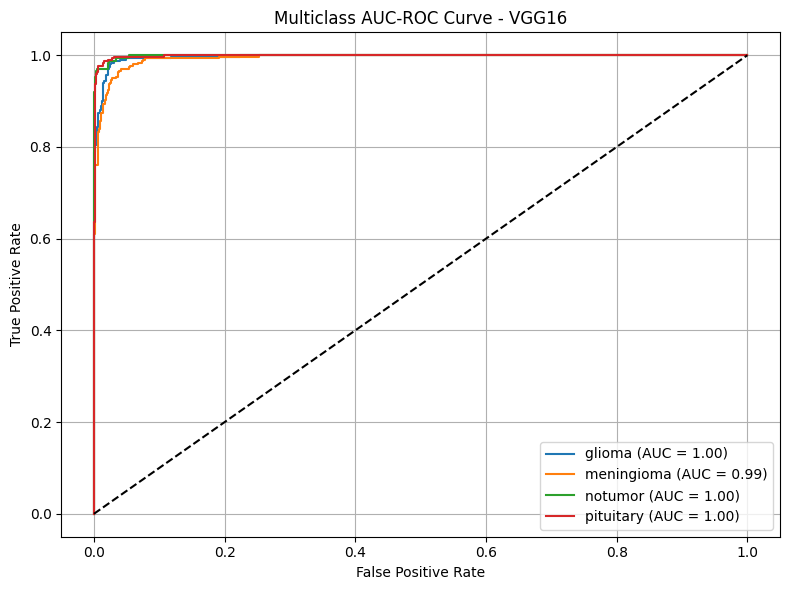

In [6]:
# 🧬 Binarize true labels
y_true_bin = label_binarize(y_true, classes=range(num_classes))

# 📉 Compute AUC for each class
auc_score = roc_auc_score(y_true_bin, y_probs, average='macro', multi_class='ovr')
print(f"AUC-ROC Score: {auc_score:.4f}")

# 🎨 Plot AUC-ROC Curve
fpr = {}
tpr = {}
roc_auc = {}

plt.figure(figsize=(8, 6))
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.title('Multiclass AUC-ROC Curve - VGG16')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.tight_layout()
plt.savefig("auc_roc_vgg16.png")
plt.show()

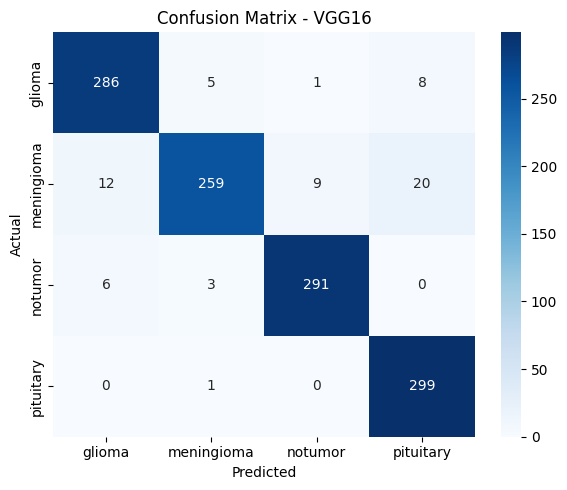

In [7]:
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix - VGG16")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig("conf_matrix_vgg16.png")
plt.show()

In [8]:
# 📄 Prepare Result Entry
model_results = {
    "Model": ["VGG16"],
    "Accuracy": [acc],
    "Precision": [cr['macro avg']['precision']],
    "Recall": [cr['macro avg']['recall']],
    "Specificity": [specificity],
    "F1-Score": [cr['macro avg']['f1-score']],
    "AUC-ROC": [auc_score],
    "TP": [tp],
    "TN": [tn],
    "FP": [fp],
    "FN": [fn]
}

results_df = pd.DataFrame(model_results)
results_file = "all_model_results.csv"

# 📥 Save Results
if os.path.exists(results_file):
    results_df.to_csv(results_file, mode='a', index=False, header=False)
else:
    results_df.to_csv(results_file, index=False)

print("✅ All metrics saved to:", results_file)

✅ All metrics saved to: all_model_results.csv
